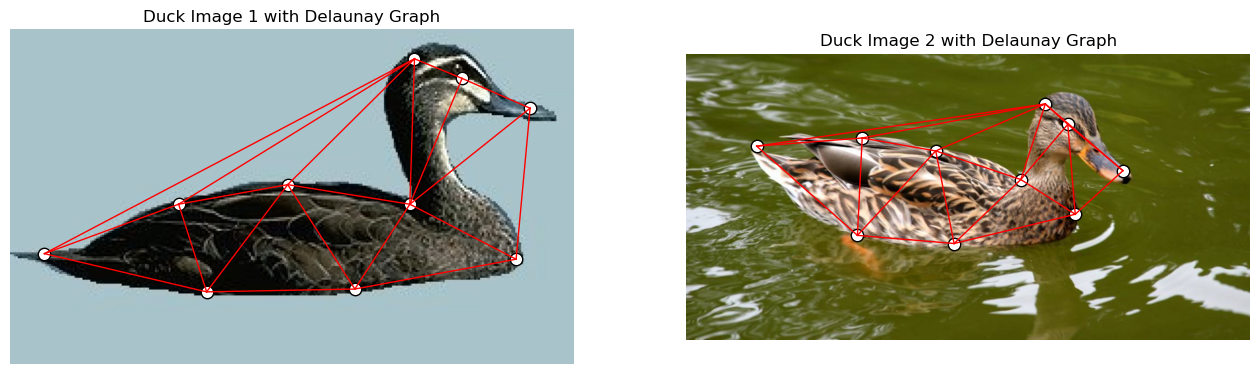

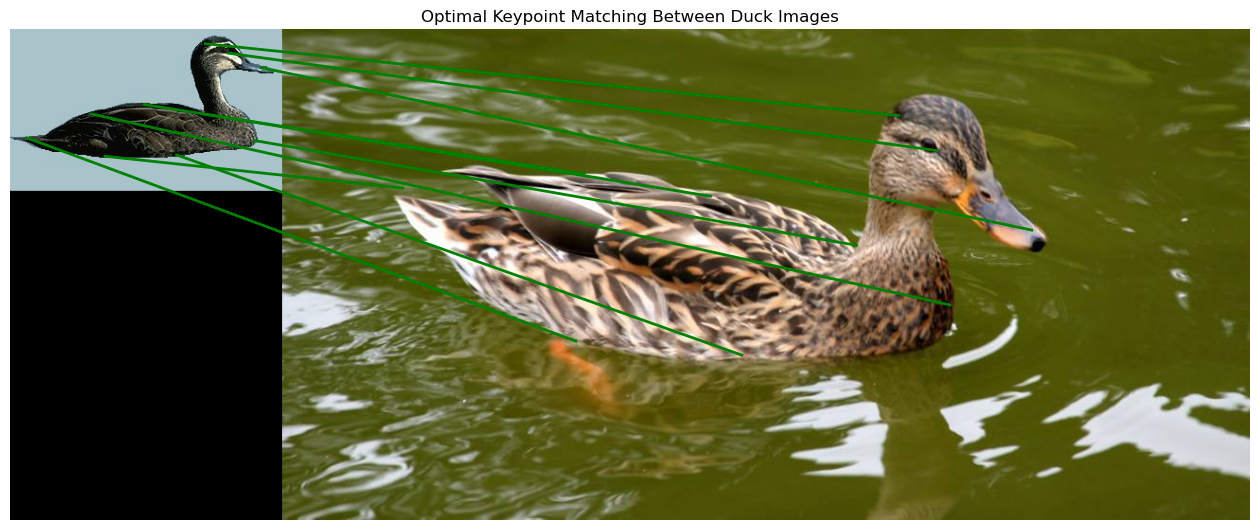

In [1]:
import numpy as np
from PIL import Image
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, distance
from scipy.optimize import linear_sum_assignment
import pandas as pd

def load_and_preprocess_images(img_path1, img_path2, mat_path1, mat_path2):
    """
    Carga y preprocesa un par de imágenes y sus keypoints.
    
    Parámetros:
        img_path1, img_path2: Paths a las imágenes.
        mat_path1, mat_path2: Paths a los archivos .mat que contienen las keypoints.
    
    Retorna:
        img1, img2: Imágenes cargadas como arrays NumPy.
        kpts1, kpts2: Keypoints en un array de tamaño (2, N) 
                       (primera fila: coordenadas x, segunda fila: coordenadas y).
    """
    # Cargar imágenes
    img1 = np.array(Image.open(img_path1))
    img2 = np.array(Image.open(img_path2))
    
    # Cargar keypoints (se asume que están almacenados bajo la clave 'pts_coord')
    kpts1 = np.array(sio.loadmat(mat_path1)['pts_coord'])
    kpts2 = np.array(sio.loadmat(mat_path2)['pts_coord'])
    
    return img1, img2, kpts1, kpts2

def delaunay_triangulation(kpts):
    """
    Construye una matriz de adyacencia a partir de la triangulación de Delaunay.
    
    Parámetros:
        kpts: Array de keypoints de tamaño (2, N).
        
    Retorna:
        A: Matriz de adyacencia binaria de tamaño (N, N) donde A[i,j]=1 indica 
           que existe un borde entre los keypoints i y j.
    """
    pts = kpts.T  # Convertir a (N, 2)
    tri = Delaunay(pts)
    N = pts.shape[0]
    A = np.zeros((N, N))
    
    # Cada simplex (triángulo) aporta tres aristas.
    for simplex in tri.simplices:
        for i in range(len(simplex)):
            for j in range(i+1, len(simplex)):
                A[simplex[i], simplex[j]] = 1
                A[simplex[j], simplex[i]] = 1
    return A

def simple_spatial_matching(kpts1, kpts2):
    """
    Realiza el matching óptimo entre dos conjuntos de keypoints usando la distancia euclidiana 
    y el algoritmo húngaro (Munkres).
    
    Args:
        kpts1: Array de keypoints del primer grafo (2xN1).
        kpts2: Array de keypoints del segundo grafo (2xN2).
    
    Retorna:
        matching: Matriz binaria (N1 x N2) donde matching[i,j]=1 indica que el keypoint i
                  de la primera imagen se empareja con el keypoint j de la segunda imagen.
    """
    pts1 = kpts1.T  # (N1, 2)
    pts2 = kpts2.T  # (N2, 2)
    
    # Crear la matriz de costes basada en la distancia euclidiana
    cost_matrix = distance.cdist(pts1, pts2, metric='euclidean')
    
    # Aplicar el algoritmo húngaro para obtener la asignación óptima
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Construir la matriz de matching
    matching = np.zeros(cost_matrix.shape, dtype=int)
    matching[row_ind, col_ind] = 1
    
    return matching

def visualize_matching_full(img1, img2, kpts1, kpts2, adj_matrix1, adj_matrix2, matching):
    """
    Visualiza el matching entre dos imágenes mostrando:
      - Cada imagen con sus keypoints y grafo (usando Delaunay).
      - Una imagen compuesta que conecta los keypoints emparejados.
    
    Parámetros:
        img1, img2: Imágenes de entrada.
        kpts1, kpts2: Arrays de keypoints (2xN1 y 2xN2).
        adj_matrix1, adj_matrix2: Matrices de adyacencia (N1xN1 y N2xN2) de los grafos.
        matching: Matriz de matching binaria (N1xN2) que indica las correspondencias.
    """
    # Visualizar cada imagen con su grafo
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Imagen 1
    axes[0].imshow(img1)
    axes[0].scatter(kpts1[0], kpts1[1], c='w', edgecolors='k', s=80)
    N1 = kpts1.shape[1]
    for i in range(N1):
        for j in range(i+1, N1):
            if adj_matrix1[i, j]:
                axes[0].plot([kpts1[0, i], kpts1[0, j]], [kpts1[1, i], kpts1[1, j]], 'r-', linewidth=1)
    axes[0].set_title("Duck Image 1 with Delaunay Graph")
    axes[0].axis('off')
    
    # Imagen 2
    axes[1].imshow(img2)
    axes[1].scatter(kpts2[0], kpts2[1], c='w', edgecolors='k', s=80)
    N2 = kpts2.shape[1]
    for i in range(N2):
        for j in range(i+1, N2):
            if adj_matrix2[i, j]:
                axes[1].plot([kpts2[0, i], kpts2[0, j]], [kpts2[1, i], kpts2[1, j]], 'r-', linewidth=1)
    axes[1].set_title("Duck Image 2 with Delaunay Graph")
    axes[1].axis('off')
    
    plt.show()
    
    # Visualización compuesta del matching
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    height = max(h1, h2)
    width = w1 + w2
    composite_img = np.zeros((height, width, 3), dtype=img1.dtype)
    composite_img[:h1, :w1, :] = img1
    composite_img[:h2, w1:w1+w2, :] = img2
    
    plt.figure(figsize=(16, 8))
    plt.imshow(composite_img)
    
    pts1 = kpts1.T
    pts2 = kpts2.T
    row_ind, col_ind = np.where(matching == 1)
    for r, c in zip(row_ind, col_ind):
        x1, y1 = pts1[r]
        x2, y2 = pts2[c]
        # Ajustar la coordenada x para la segunda imagen en la imagen compuesta.
        x2_adjusted = x2 + w1
        plt.plot([x1, x2_adjusted], [y1, y2], 'g-', linewidth=2)
    
    plt.title("Optimal Keypoint Matching Between Duck Images")
    plt.axis('off')
    plt.show()

# --- Rutas de archivos usando los paths proporcionados ---
img_path1 = '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Duck/060_0000.png'
img_path2 = '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Duck/060_0010.png'
mat_path1 = '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Duck/060_0000.mat'
mat_path2 = '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Duck/060_0010.mat'

if __name__ == "__main__":
    # Cargar imágenes y keypoints
    img1, img2, kpts1, kpts2 = load_and_preprocess_images(img_path1, img_path2, mat_path1, mat_path2)
    
    # Construir los grafos mediante triangulación de Delaunay
    adj_matrix1 = delaunay_triangulation(kpts1)
    adj_matrix2 = delaunay_triangulation(kpts2)
    
    # Realizar matching de keypoints usando el algoritmo húngaro
    matching = simple_spatial_matching(kpts1, kpts2)
    
    # Visualizar los resultados
    visualize_matching_full(img1, img2, kpts1, kpts2, adj_matrix1, adj_matrix2, matching)
    
    # (Opcional) Evaluación del matching
    # Aquí podrías comparar 'matching' con la verdad de terreno (ground truth) para calcular la precisión.
    # Por ejemplo, si tuvieras una matriz ground_truth, podrías hacer:
    # accuracy = np.sum(matching * ground_truth) / np.sum(ground_truth)
    # print("Matching Accuracy:", accuracy)
    
    # (Opcional) Guardar resultados en un CSV para distintas categorías.
    # Ejemplo: crear un DataFrame y guardarlo usando pandas.
    # results = [{'Category': 'Duck', 'Mean Accuracy': mean_acc, 'Std Accuracy': std_acc}]
    # df = pd.DataFrame(results)
    # df.to_csv("matching_accuracy_results.csv", index=False)
